# Mostly MH on pre-defined multi-variate Gaussian.

In [1]:
from copy import copy
from functools import partial
import numpy as np
import pylab as plt
from scipy.stats import norm, multivariate_normal
from scipy.interpolate import griddata

//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Helper functions

In [2]:
# Helper function for setting up distributions.
def make_means_covs_default(num_models=2, dims=2):
    means = [[0,0]] * num_models
    covs = np.ones((num_models, dims, dims)) * 0.01
    axes_covs = [0.1, 0.5]
    for i, mean in enumerate(means):
        if i == 1:
            axes_covs.reverse()
        for ax, cov in enumerate(axes_covs):
            covs[i, ax, ax] = cov
    #print 'Means:', means
    #print "Covariances:"
    #for cov in covs:
    #    print cov
    return means, covs

def make_models_default():
    means, covs = make_means_covs_default()
    return make_models(means, covs)

def make_means_covs(vars_, covars):
    num_models = len(vars_)
    dims = len(vars_[0])
    #print num_models, dims
    means = [[0,0]] * num_models
    covs = np.ones((num_models, dims, dims)) * np.asarray(covars)[:, None, None]
    for i, mean in enumerate(means):
        for ax, cov in enumerate(vars_[i]):
            covs[i, ax, ax] = cov
#     print 'Means:', means
#     print "Covariances:"
#     for cov in covs:
#         print cov
    return means, covs

def make_models(means, covs):
    return [multivariate_normal(mean, cov)
            for mean, cov in zip(means, covs)]  

In [111]:
# Plotting functions.
def get_mesh_bounds(models, num_sigma=3):
    covs = [model.cov for model in models]
    # For three sta away.
    return np.sqrt(np.max(covs)) * num_sigma

def get_mesh_xy_and_positions(models, res=.01, num_sigma=3):
    mesh_ub = get_mesh_bounds(models, num_sigma=num_sigma) + res
    mesh_lb = - mesh_ub 
    x, y = np.mgrid[mesh_lb:mesh_ub:res, mesh_lb:mesh_ub:res]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    return x, y, pos

def get_mesh_xy_and_positions_from_samples(samples):
    res = .01
    mesh_ub = np.max(samples) + res
    mesh_lb = np.min(samples)    
    x, y = np.mgrid[mesh_lb:mesh_ub:res, mesh_lb:mesh_ub:res]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    return x, y, pos

def plot_contours2d(models, ax=None):
    assert len(models[0].mean) == 2
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    x, y, pos = get_mesh_xy_and_positions(models, num_sigma=3)
    levels = [0.01] + list(np.arange(0.2, 1.2, 0.2))
    cmap = ['viridis', 'cool', 'hot']
    for i, model in enumerate(models):
        levels = [ model.pdf(point) for point in points ]
        ax.contour(x, y, model.pdf(pos), levels, cmap=cmap[i % len(cmap)], label='model %d' % i,
                   alpha=0.5)
        ax.hold(True)
    ax.set_aspect('equal')#, 'datalim')
    ax.tick_params(labelsize='xx-small')
    #ax.set_xbound(bounds[0], bounds[1])
    #ax.set_ybound(bounds[0], bounds[1])
    #ax.legend()
    #plt.colorbar(ax)
    bounds = [np.max(x), np.min(x)]
    return ax, bounds

def plot_product_of_experts(models, ax=None, res=0.005):
    #print models
    assert len(models[0].mean) == 2
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    x, y, pos = get_mesh_xy_and_positions(models, res=res)
    print 'mesh res', pos.shape
    product = np.ones(x.shape)
    for model in models:
        pdfs = model.pdf(pos)
        #print pdfs
        product *= pdfs
        #print product
    #print x.shape, y.shape
    #print 'product.shape', product.shape
    #print np.min(product), np.max(product)
    ax.contour(x, y, product, cmap='viridis',
               alpha=0.5)
    ax.set_aspect('equal')#, 'datalim')
    ax.legend()
    return ax

#def plot_samples(ax, samples):
#    for sample in samples:
#        ax.add_patch(Circle(sample, radius=0.005, 
#                     facecolor='b', edgecolor='none'))
def plot_1d_pdf(model, ax):
    xs = np.arange(-3, 3, .1)
    ax.plot(xs, model.pdf(xs))
    
def plot_samples(ax, samples, alpha=0.5, bounds=(-4, 4), title_str=None):
    #ax.autoscale(False) # To avoid that the scatter changes limits
    samples = np.asarray(samples)
    ax.scatter(samples[:, 0], samples[:, 1], s=0.5, zorder=1, alpha=alpha)
    ax.set_aspect('equal')
    if title_str is not None:
        ax.set_title(title_str, fontsize='xx-small')
    ax.tick_params(labelsize='xx-small')
    ax.set_xbound(bounds[0], bounds[1])
    ax.set_ybound(bounds[0], bounds[1])
    
def plot_sample_contour_slow(ax, samples, plot_dots=True):
    samples = np.asarray(samples)
    n, ndims = samples.shape
    print samples.shape
    if plot_dots:
        plot_samples(ax, samples, alpha=0.05)
    # Create grid for contour.
    x, y, positions = get_mesh_xy_and_positions_from_samples(samples)
    pdfs = np.zeros(x.shape)
    print positions.shape
    for sample in samples:
        pdfs += multivariate_normal.pdf(
            positions, mean=sample, cov=0.01*np.identity(ndims))
    pdfs /= n    
    ax.contour(x, y, pdfs, cmap='viridis',
               alpha=0.5)
    ax.set_aspect('equal')#, 'datalim')
    ax.legend()
    return ax

def gauss(pos, means, var=0.01):
    pos_res = pos.shape[0]
    ndim = means.shape[1]
    assert pos.shape[0] == pos.shape[1]
    assert pos.shape[2] == means.shape[1]
    pos = np.reshape(pos, (-1, 2))
    # means: (n_samples, n_dim)
    # pos: (n_positions, n_dim)
    inv_sqrt_cov = np.identity(ndim) * 1./np.sqrt(var) 
    normalization = np.power(2*np.pi, -ndim/2) * inv_sqrt_cov
    
    inv_cov = np.identity * 1./var
    # (n_positions, n_samples, n_dim)
    diff = pos[:, None, :] - means[None, :, :]
    exponent = -0.5 * np.power(diff, 2) * 1./var
    return normalization * np.exp(exponent)
        
def plot_sample_contour_slow(ax, samples, plot_dots=True):
    samples = np.asarray(samples)
    n, ndims = samples.shape
    print samples.shape
    if plot_dots:
        plot_samples(ax, samples, alpha=0.05)
    # Create grid for contour.
    x, y, positions = get_mesh_xy_and_positions_from_samples(samples)
    pdfs = np.zeros(x.shape)
    print positions.shape
    for sample in samples:
        pdfs += multivariate_normal.pdf(
            positions, mean=sample, cov=0.01*np.identity(ndims))
    pdfs /= n    
    ax.contour(x, y, pdfs, cmap='viridis',
               alpha=0.5)
    ax.set_aspect('equal')#, 'datalim')
    ax.legend()
    return ax

    
    # Does not bring out the shapes.
    #plt.hist2d(samples[:, 0], samples[:, 1], bins=100)
    
    # Z as ones doesn't show the actual density, just flat interpolation between ones.
    # z = np.ones((samples.shape[0]))
    #zi = griddata((samples[:, 0], samples[:, 1]), z, 
    #              (xi, yi), method='cubic')
                  #(xi[None,:], yi[:,None]), method='gaussian')
    # contour the gridded data, plotting dots at the randomly spaced data points.
    #ax.contour(xi,yi,zi,15,linewidths=0.5,cmap=plt.cm.viridis)
    #ax.contourf(xi,yi,zi,15,cmap=plt.cm.viridis)
    #ax.colorbar() # draw colorbar

In [112]:
def sample_mixture_gaussian(ax, models, num_samples=1000, plot_bounds=None):
    samples = []
    for i in range(num_samples):
        # Randomly chose model.
        model_idx = np.random.choice(len(models), size=1)
        model = models[model_idx]
        sample = multivariate_normal.rvs(model.mean, model.cov)
        samples.append(sample)
    samples = np.asarray(samples)
    plot_samples(ax, samples)
    ax.set_title('mixture of Gauss', fontsize='xx-small')
    ax.tick_params(labelsize='xx-small')
    if plot_bounds is not None:
        for fn in [ax.set_xbound, ax.set_ybound]:
            fn(plot_bounds[0], plot_bounds[1])
    return samples

# test plots - mixture of gaussians

/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


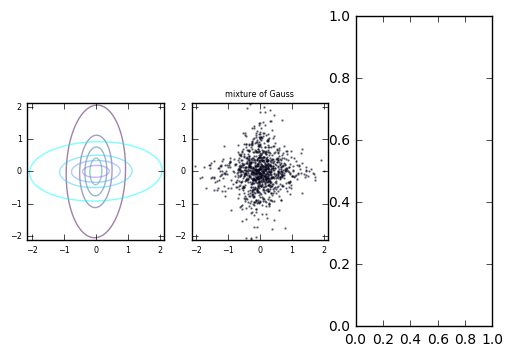

In [114]:
models = make_models_default()
fig, axes = plt.subplots(1,3)
axes = np.ravel(axes)
_, bounds = plot_contours2d(models, axes[0])
samples = sample_mixture_gaussian(axes[1], models, plot_bounds=bounds)
#plot_sample_contour_slow(axes[2], samples)
plt.show()

# test plots - product of experts

mesh res (851, 851, 2)


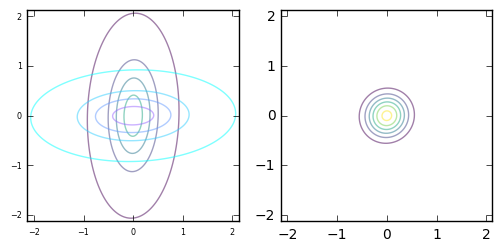

In [109]:
models = make_models_default()
fig, axes = plt.subplots(1,2)
axes = np.ravel(axes)
_, bounds = plot_contours2d(models, axes[0])
plot_product_of_experts(models, axes[1], res=0.005)
plt.show()

# Trying out distributions with different shapes.

3
mesh res (1202, 1202, 2)


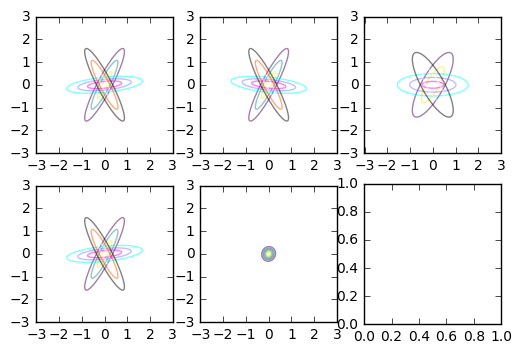

In [7]:
#means, covs = make_means_covs(vars_=[[0.3, 1], [1, 0.3], [0.3, 1]], 
#                              covars=[0.4, 0.1, -0.4])
# ?? reduce the second model's y variance to be smaller in order for the 'narrowness'
# of the three models to match.
means, covs = make_means_covs(vars_=[[0.3, 1], [1, 0.05], [0.3, 1]], 
                              covars=[0.5, 0.1, -0.5])
models = make_models(means, covs)
print len(models)
fig, axes = plt.subplots(2,3)
axes = np.ravel(axes)
plot_contours2d(models, axes[0])

means, covs = make_means_covs(vars_=[[0.3, 1], [1, 0.05], [0.3, 1]], 
                              covars=[0.5, -0.1, -0.5])
models = make_models(means, covs)
plot_contours2d(models, axes[1])

means, covs = make_means_covs(vars_=[[0.4, 1], [1, 0.1], [0.4, 1]], 
                              covars=[0.5, 0, -0.5])
models = make_models(means, covs)
plot_contours2d(models, axes[2])

means, covs = make_means_covs(vars_=[[0.3, 1], [1, 0.05], [0.3, 1]], 
                              covars=[0.5, 0.1, -0.5])
models = make_models(means, covs)
plot_contours2d(models, axes[3])
plot_product_of_experts(models, axes[4])

plt.show()

# Compute conditional distributions.

In [8]:
def compute_cond_moments(model, cond_val=None, cond_ax=None):
    # assumes two dimensional for now.
    assert len(model.mean) == 2
    # [x, y]T ~ N([a, b]T, [[A, C], [CT, B]]) 
    # => x|y ~ N(a + C B-1 (y-b), A - C B-1 CT)
    pred_ax = abs(1 - cond_ax)
    C = model.cov[1, 0]
    B = model.cov[cond_ax, cond_ax]
    mean = model.mean[pred_ax] + C * 1./B * (cond_val-model.mean[cond_ax])
    cov = model.cov[pred_ax, pred_ax] - C * 1./B * C 
    #print mean, cov, 'conditioned on cond_ax=%d, cond_val=%.2f' % (cond_ax, cond_val)
    return mean, cov
def get_cond_norm(model, **kwargs):
    mean, cov = compute_cond_moments(model, **kwargs)
    return multivariate_normal(mean, cov)
def sample_cond_norm(model, **kwargs):
    mean, cov = compute_cond_moments(model, **kwargs)
    return multivariate_normal.rvs(mean, cov)

In [9]:
def test_cond_norm(models, cond_ax=0, cond_vals=range(-1, 2, 1)):
    fig, axes = plt.subplots(2,2)
    axes = np.ravel(axes)
    plot_contours2d(models, axes[0])
    for i, ax in enumerate(axes[1:]):
        cond_model = get_cond_norm(models[0], cond_val=cond_vals[i], cond_ax=cond_ax)
        plot_1d_pdf(cond_model, ax)
    plt.show()

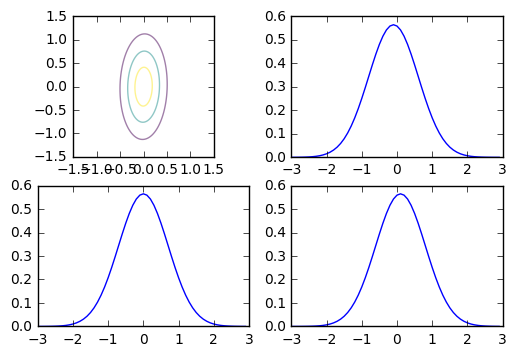

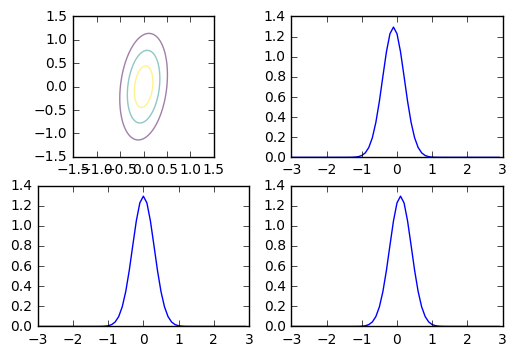

In [10]:
# Test conditional normal
means, covs = make_means_covs_default()
models = make_models(means, covs)
test_cond_norm([models[0]])
means, covs = make_means_covs(vars_=[[0.1, 0.5]], covars=[0.05]) 
models = make_models(means, covs)
test_cond_norm([models[0]], cond_ax=1)

# Gibbs sampling routines

In [11]:
#def new_sample(size_):
#    return [None] * size_

def update_sample(old_sample, update_val=None, update_ax=None):
    old_sample[update_ax] = update_val
    return old_sample

def sample_complete(sample):
    none_counts = [1 for element in sample if element is None]
    is_complete = sum(none_counts) == 0
    #if is_complete:
    #    print 'complete sample:', sample
    return is_complete

In [12]:
def fixed_pick(models=models, cond_ax=None, pick_dict=None):
    assert cond_ax is not None and pick_dict is not None
    assert cond_ax in pick_dict.keys()
    return models[pick_dict[cond_ax]]

def random_pick(models=models, **kwargs):
    rand_ind = np.random.choice(len(models), 1)
    return models[rand_ind]

In [116]:
def run_gibbs(ax, models, model_pick_fn, init_vals=None, num_samples=5000):
    # Plot background
    ax, plot_bounds = plot_contours2d(models, ax)
    # Initialization
    num_axes = len(init_vals)
    cond_ax = np.random.randint(num_axes)
    if init_vals is None:
        cond_val = np.random.random()
    else:
        cond_val = init_vals[cond_ax]
    title_str = 'starting_ax=%d, val=%.2f' % (cond_ax, cond_val)
    #print 'starting at cond_idx', cond_ax, 'cond_val', cond_val
    sample = copy(init_vals)
    samples = [init_vals]
    for i in range(num_samples):
        if i % 5000 == 0:
            print 'sample', i,
        
        model = model_pick_fn(cond_ax=cond_ax)
        
        sampled_val = sample_cond_norm(model, cond_val=cond_val, cond_ax=cond_ax)
        assert len(model.mean) == 2
        sampled_ax = 1 if cond_ax == 0 else 0
        #print 'Cond ax', cond_ax
        #print 'Sampled ax', sampled_ax
        assert cond_ax != sampled_ax
        sample = update_sample(
            sample, update_val=sampled_val, update_ax=sampled_ax)
        #print 'sample:', sample
        if sample_complete(sample):
            #print 'adding sample...'
            samples.append(copy(sample))
            
        # Update axes: switch between the two axes.
        # Or randomly choose.
        cond_ax = np.random.randint(num_axes)
        #cond_ax = 1 if cond_ax == 0 else 0 
        cond_val = sample[cond_ax]
        
    samples = np.asarray(samples)
    #print samples.shape
    plot_samples(ax, samples)
    ax.set_aspect('equal')
    ax.set_title(title_str, fontsize='xx-small')
    ax.tick_params(labelsize='xx-small')
    for fn in [ax.set_xbound, ax.set_ybound]:
        fn(plot_bounds[0], plot_bounds[1])

# Experiments

Starting cell...


/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


sample 0

/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


 sample 0 sample 0 sample 0 sample 0 sample 0 sample 0 sample 0

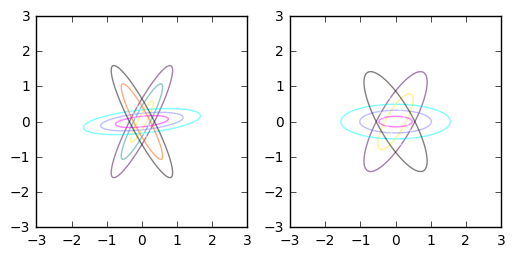

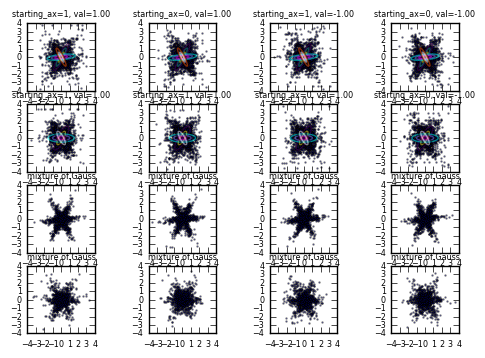

In [14]:
# TODO: implement axes picking scheme.
# TODO: implement generating from mixture of gaussian and compare.
# TODO: make contour lines be at the sigma points.
# TODO: implement and plot summing of two gaussians to compare...

# Setup
print 'Starting cell...'
#means, covs = make_means_covs(vars_=[0.1, 1], covar=[0.1])
means_covs_sets = []
means_covs_sets.append(make_means_covs(vars_=[[0.3, 1], [1, 0.05], [0.3, 1]], 
                                       covars=[0.5, 0.1, -0.5]))
#means_covs_sets.append(make_means_covs(vars_=[[0.3, 1], [1, 0.05], [0.3, 1]], 
#                                       covars=[0.5, -0.1, -0.5]))
means_covs_sets.append(make_means_covs(vars_=[[0.4, 1], [1, 0.1], [0.4, 1]], 
                                       covars=[0.5, 0, -0.5]))
model_sets = []
fig, axes = plt.subplots(1,2)
axes = np.ravel(axes)
for i, (means, covs) in enumerate(means_covs_sets):
    models = make_models(means, covs)
    plot_contours2d(models, axes[i])
    model_sets.append(models)

num_dims = len(means[0])
num_samples = 1000 * num_dims

# Setup model picking functions
fixed = partial(fixed_pick, models=models, pick_dict={1:1, 0:0})
fixed_other = partial(fixed_pick, models=models, pick_dict={1:0, 0:1})
random = partial(random_pick, models=models)

pick_funcs = [fixed, fixed_other, random]
pick_funcs = [random]

num_rows = 4
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols)
#axes = np.ravel(axes)
init_presets = [[-1, 1], [1, 1], [1, -1], [-1, -1]]
assert len(pick_funcs) <= len(axes)
for i, pick_func in enumerate(pick_funcs):
    for j, init_vals in enumerate(init_presets):
        # Multiple initializations.
        assert len(model_sets) <= num_rows / 2
        for k, models in enumerate(model_sets):
            # sample init vals.
            model = random()
            #init_vals = multivariate_normal.rvs(model.mean, model.cov)
            #init_vals = init_presets[i]
            ax = axes[k, j]
            run_gibbs(ax, models, pick_func, init_vals, num_samples=num_samples)
            # Compare to sampling from mixture of gaussian.
            sample_mixture_gaussian(axes[num_rows/2 + k,j], models)
plt.show()

In [15]:
def sample_product_of_gaussian(models, axes, num_samples=1000):
    # Plot background
    for ax in axes:
        plot_contours2d(models, ax)
    products = []
    samples = []
    reject_count = 0
    rejected_samples = []
    for i in range(num_samples):
        # Choose model for proposal and sample from it.
        proposal_model = models[0]
        # TODO: Could sample multiple samples and then won't have to loop over.
        sample = multivariate_normal.rvs(proposal_model.mean, proposal_model.cov)
        # product of pdf for the others.
        product = 1
        for model in models[1:]:
            product *= model.pdf(sample)
        products.append(product)
        if product >= 1:
            samples.append(sample)
        elif product < 1 and product > 0:
            accept_prob = np.random.random_sample()
            if product > accept_prob:
                samples.append(sample)
            else:
                reject_count += 1
                rejected_samples.append(sample)
        else:
            assert False, 'Product of densities should not be zero'
            
    plot_samples(axes[0], samples, title_str='accept')
    plot_samples(axes[1], rejected_samples, title_str='reject')
    print 'reject_ratio', float(reject_count) / num_samples
    #print products[:100]
    return samples

reject_ratio 0.9622


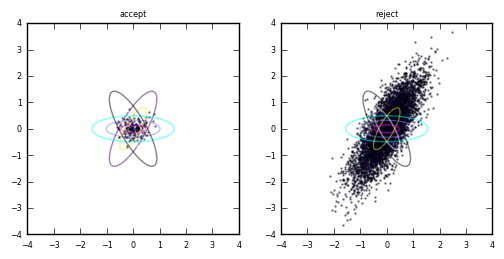

reject_ratio 0.9652


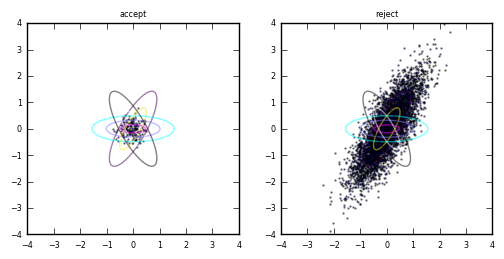

In [16]:
for modes in model_sets:
    fig, axes = plt.subplots(1,2)
    axes = np.ravel(axes)
    samples = sample_product_of_gaussian(models, axes, num_samples=5000)
    plt.show()

# MH product of gaussians

In [118]:
def poe_pdf(models, x):
    product = 1
    for model in models:
        product *= model.pdf(x)
    return np.power(product, 1./len(models))

def stoachastic_poe_pdf(x, models_to_subsample=None, subsample_count=None, 
                        preselected_models=None):
    if preselected_models is not None and subsample_count is not None:
        assert False, 'If preselected models are given, assumes all would be used and not subsampled'
    if preselected_models is not None and models_to_subsample is not None:
        assert False, 'If preselected models are given, assumes would not need another set of models to choose from.'
    if preselected_models is None and models_to_subsample is None:
        assert False, 'Not models to choose from.'
    if models_to_subsample is None and subsample_count == 0:
        assert False, 'subsample_count can not be zero.  Need to at least sample one model.'
    poe_models = None
    if preselected_models is not None:
        poe_models = preselected_models
    elif models_to_subsample is not None and subsample_count is None:
        poe_models = models_to_subsample
    elif models_to_subsample is not None:
        inds = np.random.choice(len(models_to_subsample), subsample_count, replace=False)
        poe_models = [models_to_subsample[ind] for ind in inds]
    else:
        assert False, 'Unexpected setup.'
    return poe_pdf(poe_models, x), poe_models

def mh_product_of_gaussians(models, axes, model_subsample_count, sigma2, init_val=None,
                            num_samples=1000, burnin=500, plot_bounds=None):
    num_samples = num_samples + burnin
    # Plot background
    for ax in axes:
        plot_contours2d(models, ax)
    if init_val is None:
        model = models[np.random.randint(len(models))]
        init_val = multivariate_normal.rvs(model.mean, model.cov)
    ndim = models[0].mean.size
    samples = [init_val]
    
    for i in range(num_samples):
        # Propose sample
        sample = multivariate_normal.rvs(samples[-1], sigma2 * np.identity(ndim))
        current_pdf, preselected_models = stoachastic_poe_pdf(
            sample, models_to_subsample=models, 
            subsample_count=model_subsample_count)
        previous_pdf, _ = stoachastic_poe_pdf(
            samples[-1], preselected_models=preselected_models)
        ratio = current_pdf / previous_pdf
        accept_prob = np.minimum(1, ratio)
        alpha = np.random.random_sample()
        if alpha <= accept_prob:
            samples.append(sample)
        else:
            samples.append(samples[-1])
    init_str = 'init_val=(%.2f,%.2f)' % (init_val[0], init_val[1]) 
    title_prefix = '%d-model '% model_subsample_count
    plot_samples(axes[0], samples[burnin:], bounds=plot_bounds,
                 title_str=title_prefix + 'MH, prop var=%.4f, w/o burn-in, %s' % (sigma2, init_str))
    plot_samples(axes[1], samples, bounds=plot_bounds,
                 title_str=title_prefix + 'MH, prop var=%.4f, %s' % (sigma2, init_str))
    return samples

/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


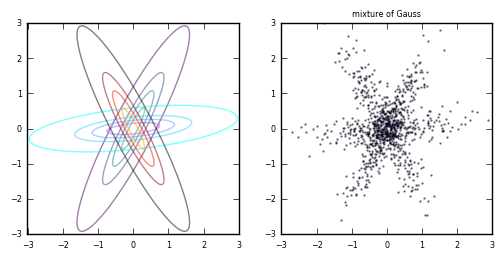

In [117]:
fig, axes = plt.subplots(1,2)
models = model_sets[0]
_, plot_bounds = plot_contours2d(ax=axes[0], models=models)
samples = sample_mixture_gaussian(axes[1], models, plot_bounds=bounds)
plt.show()

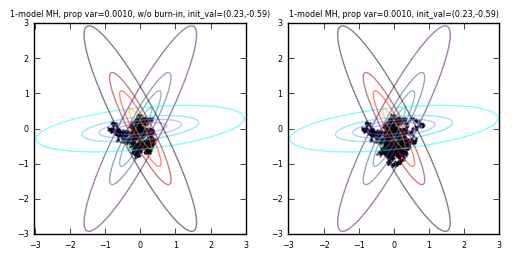

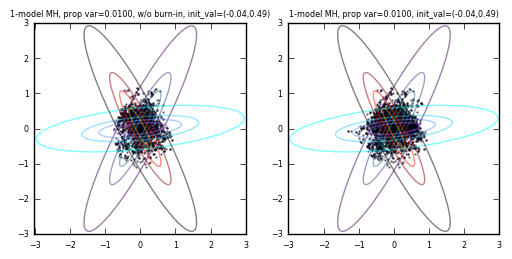

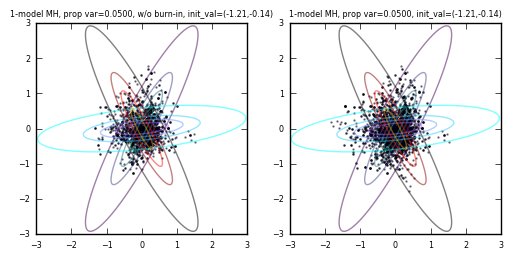

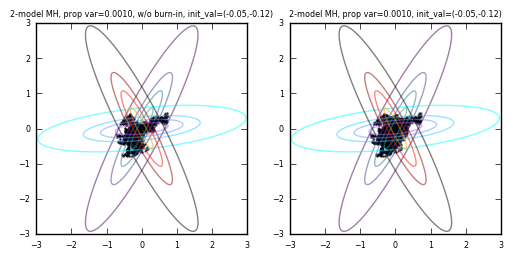

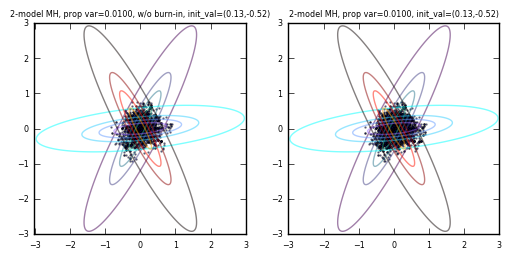

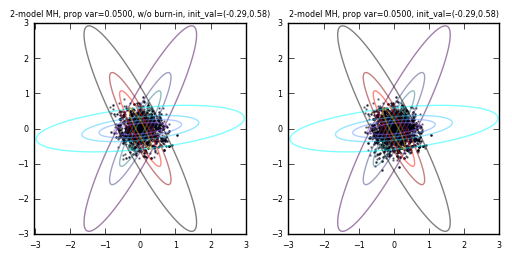

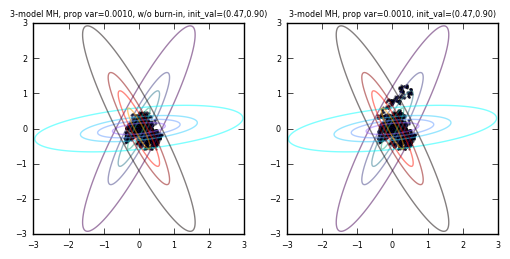

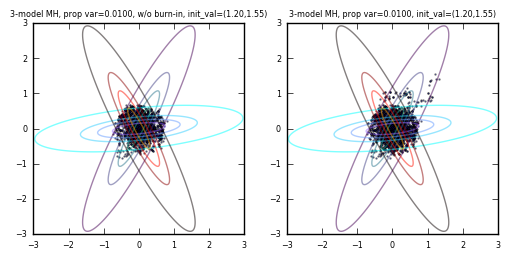

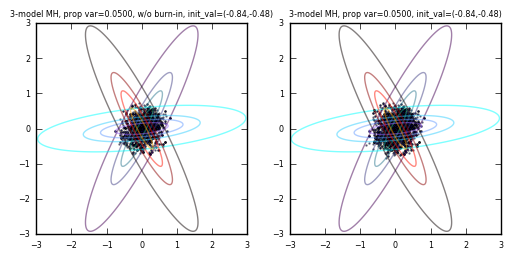

In [119]:
for i, models in enumerate(model_sets[:1]):
    for model_subsample_count in range(1, len(models)+1):
        for sigma2 in [0.001, 0.01, 0.05]:
            fig, axes = plt.subplots(1,2)
            axes = np.ravel(axes)
            samples = mh_product_of_gaussians(
                models, axes, model_subsample_count, 
                sigma2, init_val=None, num_samples=2000, burnin=1000,
                plot_bounds=plot_bounds)
            plt.show()

0.815807260395 -0.841170815698


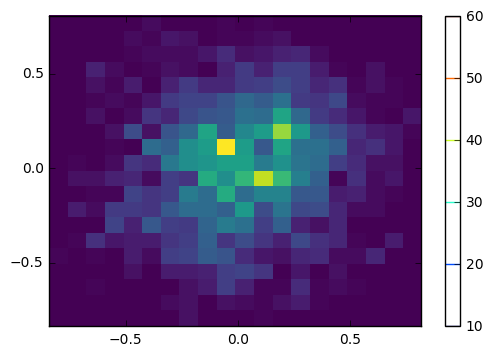

3001


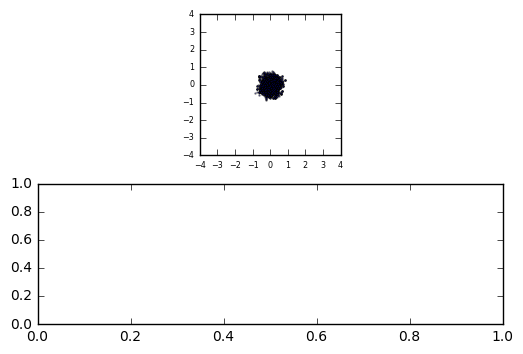

In [129]:
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter
len(samples)
samples = np.asarray(samples)
print np.max(samples), np.min(samples)
retvals = plt.hist2d(samples[:, 0], samples[:, 1], bins=20, 
                     cmap='viridis')
counts = retvals[0]
sigma = 0.001
counts = gaussian_filter(counts, sigma)
plt.contour(counts)
plt.colorbar()

if False:
    print np.max(samples), np.min(samples)
    retvals = plt.hist2d(samples[:, 0], samples[:, 1], bins=20)
    #plt.show()
    z, x, y, _ = retvals
    x, y = x[:-1], y[:-1]
    print z.shape, x.shape, y.shape
    res = 0.01
    xi, yi = np.mgrid[-2:2:res, -2:2:res]
    print xi.shape, yi.shape
    zi = griddata((x, y), z, (xi, yi))#, method='cubic')
    CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
plt.show()
print len(samples)
fig, axes = plt.subplots(2,1)
plot_samples(axes[0], samples)
plt.show()

mesh res (1202, 1202, 2)
mesh res (1202, 1202, 2)


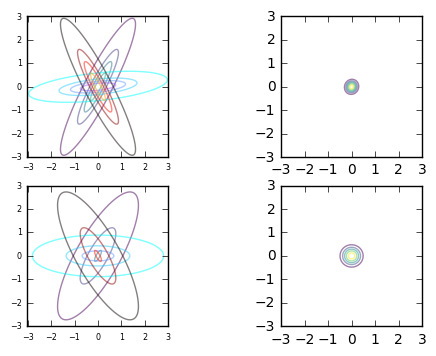

In [130]:
plt.figure()
fig, axes = plt.subplots(2, 2)
axes = np.ravel(axes)
for k, models in enumerate(model_sets):
    plot_contours2d(models, axes[2*k])
    plot_product_of_experts(models, axes[2*k+1])
plt.show()

In [21]:
def plot_eigs(cov):
    models = make_models([[0,0]], cov)
    ax = plot_contours2d(models)
    evals, evecs = np.linalg.eig(cov)
    print evals
    print evecs[0]
    for eval_, evec in zip(evals[0], evecs[0]):
        ax.arrow(0, 0, eval_*evec[0], eval_*evec[1], 
                 head_width=0.05, head_length=0.1, fc='k', ec='k')
    plt.show()

[[ 0.08902278  1.01097722]]
[[-0.99402894 -0.10911677]
 [ 0.10911677 -0.99402894]]


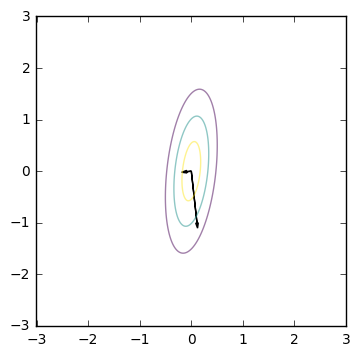

In [22]:
cov = [[[ 0.1,  0.1], 
       [ 0.1,  1. ]]]
plot_eigs(cov)

[[ 0.05755711  1.04244289]]
[[-0.97821561 -0.20759149]
 [ 0.20759149 -0.97821561]]


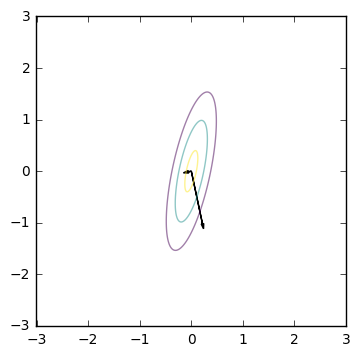

In [23]:
cov = [[[ 0.1,  0.2],
       [ 0.2,  1. ]]]
plot_eigs(cov)